In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Y_GT_X = 1
X_GT_Y = -1
POINT_COUNT = 5

# Generación de puntos
x_range = y_range = (0, 5)
x_lim = y_lim = x_range[1]

split_points = { Y_GT_X: [], X_GT_Y: []}
points_per_class = { Y_GT_X: POINT_COUNT, X_GT_Y: POINT_COUNT }

rng = np.random.default_rng()
klass_pred = { Y_GT_X: '>', X_GT_Y: '<' }

def klass_range(x, klass):
    return (0, x) if klass == X_GT_Y else (x, y_lim)

def generate_points(n, x_range, y_range, klass):
    data = rng.uniform(x_range[0], x_range[1], size=n)
    return list(map(lambda x: (x, rng.uniform(*klass_range(x, klass)), klass), data))

for klass, n in points_per_class.items():
    split_points[klass] = generate_points(n, x_range, y_range, klass)

points = split_points[Y_GT_X] + split_points[X_GT_Y]
df = pd.DataFrame(points, columns=['x', 'y', 'class'])
df.head()

,x,y,class
0,3.850859,4.155765,1
1,0.977310,4.238239,1
2,3.919176,4.600340,1
3,2.601982,3.164441,1
4,0.524768,3.527320,1


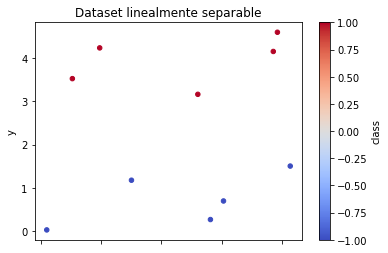

In [10]:
df.plot.scatter('x', 'y', c='class', colormap='coolwarm', title='Dataset linealmente separable')
xs = np.linspace(0, 5, 1000)

In [11]:
def calculate_h(w, point):
    return sum([w[j] * point[j] for j in range(0, len(w))])


def calculate_o(h):
    return 1 if h > 0 else -1


def calculate_error(data, w):
    err = 0
    for index, row in data.iterrows():
        h = calculate_h(w, row)
        o = calculate_o(h)
        err += abs(row['class'] - o)
    return err


def get_weights(data, eta=0.1, iterations=1000, stdout=False):
    i = 0
    w = [0 for i in range(len(data.loc[0]) - 1)]
    w_min = w
    error = 1
    error_min = len(df)
    threshold = w[0]  # TODO: ask
    
    while error > 0 and i < iterations:
        random_index = rng.integers(0, len(data))
        point = data.iloc[random_index]
        h = calculate_h(w, point)
        o = calculate_o(h)
        delta_w = eta * (point['class'] - o) * point[0:len(point) - 1]
        w += delta_w
        error = calculate_error(data, w)
        if error < error_min:
            error_min = error
            w_min = w
        
        i += 1
        
        if stdout:
            print(f"error: {error}; point: {list(point)}; h: {h}; o: {o}; delta_w: {list(delta_w)}; w: {list(w)}")
    
    return w_min, error_min

In [12]:
ws, err_m = get_weights(df)
print(f"Error: {err_m}\n")
print(ws)

Error: 0.0

x   -0.795519
y    0.966115
Name: 8, dtype: float64


0.8234211120159405


Text(0.5, 1.0, 'Dataset linealmente separable + pendiente')

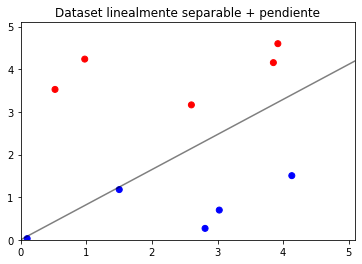

In [13]:
# w1*x + w2*y + b = 0
fig, ax = plt.subplots()
ax.scatter(list(df['x']), list(df['y']), c=list(df['class']), cmap='bwr')
yi = - ws[0] * 0 / ws[1]
yf = - ws[0] * 1 / ws[1]
print(yf)
ax.plot([0, 1], [yi, yf], color='Black', alpha=0.5, transform=ax.transAxes)
plt.xlim([0, 5.1])
plt.ylim([0, 5.1])
plt.title('Dataset linealmente separable + pendiente')

In [15]:
def classify(x, y, w):
    h = calculate_h(w, (x, y))
    o = calculate_o(h)
    return o

print(classify(2, 0, ws))

-1


In [16]:
# y = mx + b
a = yf - yi
b = 1
c = 0 # w0

init_pointt = np.array((0, yi))
final_pointt = np.array((1, yf))

In [18]:
import math

def get_distance_vector(point1, point2):
    return (point1[0] - point2[0], point1[1] - point2[1])

def get_shortest_distance(point, init_point, final_point):
    p3 = np.array((point[0], point[1]))
    return np.linalg.norm(np.cross(final_point-init_point, init_point-p3))/np.linalg.norm(final_point-init_point)

def select_closest_points(data, n=3):
    result = { Y_GT_X: [], X_GT_Y: []}
    distances = { Y_GT_X: [], X_GT_Y: []} # Distance from each point to hyperplane
    for klass in data.keys():
        for index, point in enumerate(data[klass]):
            distances[klass].append((index, get_shortest_distance(point, init_pointt, final_pointt)))
        distances[klass].sort(key=lambda tup: tup[1])
        closest_n_distances = distances[klass][0:n]
        closest_class_points = list(map(lambda tup: data[klass][tup[0]], closest_n_distances))
        result[klass] = closest_class_points
    
    return result

def get_middle_point(point1, point2):
    diff_vector = get_distance_vector(point2, point1)
    return (point1[0] + diff_vector[0] / 2, point1[1] + diff_vector[1] / 2)

# C = -Ax -By
def get_plane_constant(plane_point, norm_vector):
    return - norm_vector[0] * plane_point[0] - norm_vector[1] * plane_point[1]

def classify_point(x, y, A, B, C):
    fx = C + A * x + B * y
    return 1 if fx > 0 else -1

def get_hyperplane_margin(A, B, C):
    init_plane_point = np.array((0, - (A * 0 + C) / B))
    final_plane_point = np.array((1, - (A * 1 + C) / B))
    
    min_distance = -1
    for point in points:
        if classify_point(point[0], point[1], A, B, C) != point[2]:
            return None
        
        d = get_shortest_distance(point, init_plane_point, final_plane_point)
        if min_distance == -1 or d < min_distance:
            min_distance = d
            
    return min_distance

closest_points = select_closest_points(split_points, 4)

biggest_margin = None
chosen_hyperplane = []

for klass in closest_points.keys():
    other_klass = -1 if klass == 1 else 1
    for i in range(0, len(closest_points[klass])):
        point1 = closest_points[klass][i]
        for j in range(i+1, len(closest_points[klass])):
            point2 = closest_points[klass][j]
            dir_vector = get_distance_vector(point1, point2)
            normal_vector = np.array([dir_vector[1], -dir_vector[0]])
            normal_vector /= np.linalg.norm(normal_vector) # [A, B]
            
            for k in range(0, len(closest_points[other_klass])):
                point3 = closest_points[other_klass][k]
                middle_point = get_middle_point(point1, point3)
                C = get_plane_constant(middle_point, normal_vector) # C
                
                margin = get_hyperplane_margin(normal_vector[0], normal_vector[1], C)
                
                if margin is not None and (biggest_margin is None or margin > biggest_margin):
                    biggest_margin = margin
                    chosen_hyperplane = [normal_vector[0], normal_vector[1], C] # [A, B, C]

print(f'Hyperplane margin: {biggest_margin}')
print(f'Optimal hyperplane: {chosen_hyperplane}')

Hyperplane margin: 0.9179026125370273
Optimal hyperplane: [-0.12349051965193561, 0.992345752021993, -1.9009967275566748]


Text(0.5, 1.0, 'Dataset linealmente separable + hiperplano óptimo')

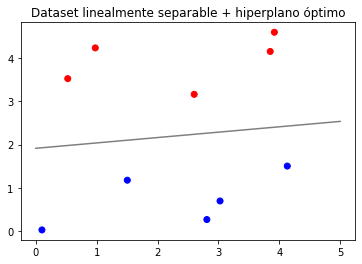

In [19]:
# w1*x + w2*y + b = 0
fig, ax = plt.subplots()
ax.scatter(list(df['x']), list(df['y']), c=list(df['class']), cmap='bwr')
A = chosen_hyperplane[0]
B = chosen_hyperplane[1]
C = chosen_hyperplane[2]
yi = - (A * 0 + C) / B
yf = - (A * 5 + C) / B
ax.plot([0, 5], [yi, yf], color='Black', alpha=0.5)#, transform=ax.transAxes)
#plt.xlim([0, 5.1])
#plt.ylim([0, 5.1])
plt.title('Dataset linealmente separable + hiperplano óptimo')

In [22]:
# Non-linearly separable dataset

MISMATCH_CLASS_DELTA_Y = 1

mismatch_points_per_class = { Y_GT_X: 1, X_GT_Y: 1 }
split_points_2 = { Y_GT_X: [], X_GT_Y: []}

def klass_range_mismatch(x, klass):
    return (x, min(x + MISMATCH_CLASS_DELTA_Y, y_lim)) if klass == X_GT_Y else (x, max(x - MISMATCH_CLASS_DELTA_Y, 0))

def get_klass_range(x, klass, mismatch):
    return klass_range(x, klass) if not mismatch else klass_range_mismatch(x, klass)

def generate_points_non_linear(n, x_range, y_range, klass, mismatch=False):
    data = rng.uniform(x_range[0], x_range[1], size=n)
    return list(map(lambda x: (x, rng.uniform(*get_klass_range(x, klass, mismatch)), klass), data))

for klass, n in points_per_class.items():
    split_points_2[klass] = generate_points_non_linear(n, x_range, y_range, klass)

for klass, n in mismatch_points_per_class.items():
    split_points_2[klass] += generate_points_non_linear(n, x_range, y_range, klass, True)

points_2 = split_points_2[Y_GT_X] + split_points_2[X_GT_Y]
df_2 = pd.DataFrame(points_2, columns=['x', 'y', 'class'])
df_2.head()

,x,y,class
0,1.583401,4.539943,1
1,4.956707,4.988577,1
2,1.337904,4.519432,1
3,2.688033,3.897614,1
4,0.829525,4.133579,1


Text(0.5, 1.0, 'Dataset no linealmente separable + recta y=x')

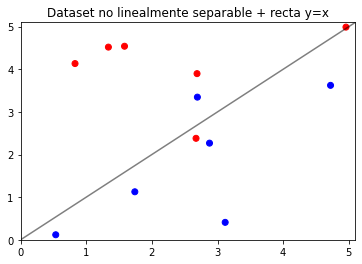

In [23]:
fig, ax = plt.subplots()
ax.scatter(list(df_2['x']), list(df_2['y']), c=list(df_2['class']), cmap='bwr')
ax.plot([0, 1], [0, 1], color='Black', alpha=0.5, transform=ax.transAxes)
plt.xlim([0, 5.1])
plt.ylim([0, 5.1])
plt.title('Dataset no linealmente separable + recta y=x')

In [24]:
ws_2, err_m_2 = get_weights(df_2)
print(f"Error: {err_m_2}\n")
print(ws_2)

Error: 2.0

x   -2.227108
y    1.761247
Name: 10, dtype: float64


1.264506072802843


Text(0.5, 1.0, 'Dataset no linealmente separable + pendiente')

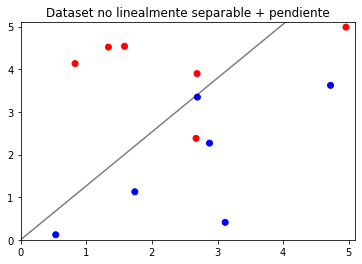

In [25]:
# w1*x + w2*y + b = 0
fig2, ax2 = plt.subplots()
ax2.scatter(list(df_2['x']), list(df_2['y']), c=list(df_2['class']), cmap='bwr')
yi_2 = - ws_2[0] * 0 / ws_2[1]
yf_2 = - ws_2[0] * 1 / ws_2[1]
print(yf_2)
ax2.plot([0, 1], [yi_2, yf_2], color='Black', alpha=0.5, transform=ax2.transAxes)
plt.xlim([0, 5.1])
plt.ylim([0, 5.1])
plt.title('Dataset no linealmente separable + pendiente')

In [26]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def get_svm(data):
    X = np.array(list(map(lambda point: (point[0], point[1]), data)))
    y = list(map(lambda point: point[2], data))

    # Create a linear SVM classifier
    clf = SVC(kernel='linear')

    # Train classifier
    clf.fit(X, y)
    
    return X, y, clf

In [34]:
def plot_svm2(X, Y, clf, lin_separable=True):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    b = clf.support_vectors_[0]
    yy_down = a * xx + (b[1] - a * b[0])
    b = clf.support_vectors_[-1]
    yy_up = a * xx + (b[1] - a * b[0])

    # plot the line, the points, and the nearest vectors to the plane
    plt.plot(xx, yy, 'k-', alpha=0.5)
    if lin_separable:
        plt.plot(xx, yy_down, 'k--', alpha=0.5)
        plt.plot(xx, yy_up, 'k--', alpha=0.5)

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.bwr)

    plt.xlim([0,5.1])
    plt.ylim([0,5.1])
    plt.title(f'SVM - dataset {"" if lin_separable else "no"} linealmente separable')
    plt.show()

In [29]:
X, y, clf = get_svm(points)

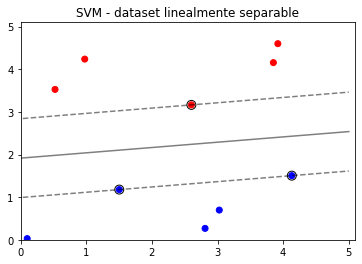

In [30]:
plot_svm2(X, y, clf)

In [31]:
X2, y2, clf2 = get_svm(points_2)

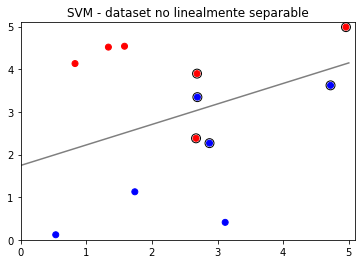

In [35]:
plot_svm2(X2, y2, clf2, False)